# Partial GT on the 9-state Network

The model network comprises 994 nodes and 4320 bidirectional edges, and
can roughly be divided into 9 competing macrostates. There are also high
energy nodes and a couple of small features, so the network is a
realistic and challenging example. The node degree distribution is
fitted to a Poisson function and the energy barrier heights have some
spread arising from the underlying potential + numerical noise. This is
realistic and will allow us to look at the effect of partial GT
heuristics based on node degree, waiting time, and energy.

Between T=10 and T=0.1 the network exhibits rate constants in the range
10^{-3} to 10^{-30}, with multi-state and multi-pathway kinetics. The
metastability at ambient temperatures (eg T=1, where the MFPT is around
6.5 x 10^{12}) renders standard kMC useless, but kPS does just fine. I
have also uploaded some kPS results at T=1 including the FPT
distribution, transition path probability densities and committor
probabilities.

In [1]:
import numpy as np
from io import StringIO
import time,os, importlib
from tqdm import tqdm
np.set_printoptions(linewidth=160)
import lib.ktn_io as kio
import lib.partialGT as pgt
import lib.gt_tools as gt
from scipy.sparse import save_npz,load_npz, diags, eye, csr_matrix,bmat
from scipy.sparse.linalg import eigs,inv,spsolve
from scipy.sparse.csgraph import connected_components
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from pathlib import Path
import seaborn as sns
sns.set()
%matplotlib inline

Using tqdm package for pretty progress bars!


In [4]:
# index_sel = which states in data file are part of largest connected component and hence are included in KTN
# only states where index_sel = True feature in K,D,B etc. i.e. N = index_sel.sum()
# B: braching prob, K = rates, D = total rate per state, u = energy, s = entropy, Emin = min E, 

data_path = Path("KTN_data/9state")
temp = 10.
beta = 1./temp
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
#non-csr matrix version of D:
D = np.ravel(K.sum(axis=0)) 
#free energy of minima
BF = beta*u-s
#rescaled
BF -= BF.min()
# AB regions
AS,BS = kio.load_AB(data_path,index_sel)
Amin = 585
Bmin = 827
print(f'Num in A: {AS.sum()}')
print(f'Num in B: {BS.sum()}')
print(f'Num in I: {index_sel.sum() - AS.sum() - BS.sum()}')
communities = pgt.read_communities(data_path/'communities_bace.dat', index_sel)
for ci in communities:
    if communities[ci][Amin - 1]:
        print(f"Community A: {ci}")
    if communities[ci][Bmin - 1]:
        print(f"Community B: {ci}")

Connected Clusters: 1, 1st 400 states in largest cluster: 1
cc: N: 994->994 (994,) (994,)
Num in A: 98
Num in B: 53
Num in I: 843
Community B: 3
Community A: 7


## Choosing Nodes to Eliminate

In [5]:
#Attempt to rank nodes based on free energy, escape time, node degree, and see what we get
def rank_nodes_to_eliminate(beta=1.0/0.25, rm_type='hybrid', percent_retained=10, 
                            log=False, escape_time_upper_bound=None):
    Nmax = None
    data_path = "KTN_data/9state"
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,screen=False)
    D = np.ravel(K.sum(axis=0)) #array of size (N,) containing escape rates for each min
    BF = beta*u-s
    BF -= BF.min()
    escape_times = 1.0/D
    node_degree = B.indptr[1:] - B.indptr[:-1]
    print(f'Number of nodes with >1 connection: {len(node_degree[node_degree > 1])}')
    #AS,BS = kio.load_AB(data_path,index_sel)
    AS = np.zeros(N, bool)
    BS = np.zeros(N, bool)
    AS[Amin-1] = True
    BS[Bmin-1] = True
    IS = np.zeros(N, bool)
    IS[~(AS+BS)] = True
    print(f'A: {AS.sum()}, B: {BS.sum()}, I: {IS.sum()}')
    
    rm_reg = np.zeros(N,bool)
    #color nodes that we would propose to remove
    if rm_type == 'node_degree':
        rm_reg[node_degree < 2] = True
        rm_reg[(AS+BS)] = False #only remove the intermediate nodes this time

    if rm_type == 'escape_time':
        #remove nodes with the smallest escape times
        #retain nodes in the top percent_retained percentile of escape time
        rm_reg[IS] = escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained)

    if rm_type == 'free_energy':
        rm_reg[IS] = BF[IS] > np.percentile(BF[IS], percent_retained)
    
    if rm_type == 'combined':
        rho = np.exp(-BF)
        rho /= rho.sum()
        combo_metric = escape_times * rho
        rm_reg[IS] = combo_metric[IS] < np.percentile(combo_metric[IS], 100.0 - percent_retained)
        
    if rm_type == 'hybrid':
        #remove nodes in the top percent_retained percentile of escape time
        time_sel = (escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained))
        bf_sel = (BF[IS]>np.percentile(BF[IS],percent_retained))
        sel = np.bitwise_and(time_sel, bf_sel)
        #that are also in the lowest percent_retained percentile of free energy
        rm_reg[IS] = sel
    
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15,4))
    colors = sns.color_palette("Paired")
    #node degree vs escape time
    ax.scatter(node_degree[~rm_reg], escape_times[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax.scatter(node_degree[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    ax.scatter(node_degree[BS], escape_times[BS], color=colors[1], alpha=0.8, label='B')
    ax.scatter(node_degree[rm_reg], escape_times[rm_reg], color=colors[9], alpha=0.4, label='rm')
    ax.set_xlabel('Node Degree')
    ax.set_ylabel('Escape Time')
    if log:
        ax.set_yscale('log')
    if escape_time_upper_bound is not None:
        ax.set_ylim([-1.0, escape_time_upper_bound])
    ax.legend()
    #free energy vs escape time
    ax1.scatter(BF[~rm_reg], escape_times[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax1.scatter(BF[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    ax1.scatter(BF[BS], escape_times[BS], color=colors[1], alpha=0.8, label='B')
    ax1.scatter(BF[rm_reg], escape_times[rm_reg], color=colors[9], alpha=0.4, label='rm')
    ax1.set_xlabel('Free Energy')
    ax1.set_ylabel('Escape Time')
    if log:
        ax1.set_yscale('log')
    if escape_time_upper_bound is not None:
        ax.set_ylim([-1.0, escape_time_upper_bound])
    ax1.legend()
    #node degree vs free energy
    ax2.scatter(BF[~rm_reg], node_degree[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax2.scatter(BF[AS], node_degree[AS], color=colors[5], alpha=0.8, label='A')
    ax2.scatter(BF[BS], node_degree[BS], color=colors[1], alpha=0.8, label='B')
    ax2.scatter(BF[rm_reg], node_degree[rm_reg], color=colors[9], alpha=0.4, label='rm')
    ax2.set_xlabel('Free Energy')
    ax2.set_ylabel('Node Degree')
    ax2.legend()
    plt.show()
    fig.tight_layout()

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


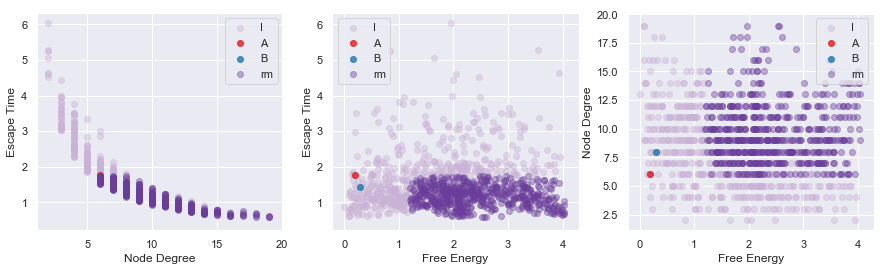

In [23]:
rank_nodes_to_eliminate(beta=1./10., percent_retained=25, rm_type='hybrid')

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


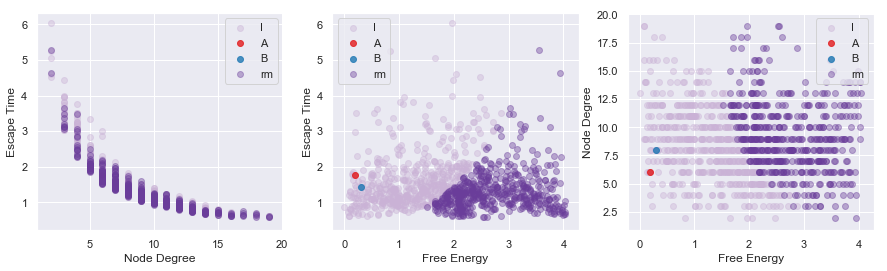

In [31]:
rank_nodes_to_eliminate(beta=1./10., percent_retained=50, rm_type='combined')

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


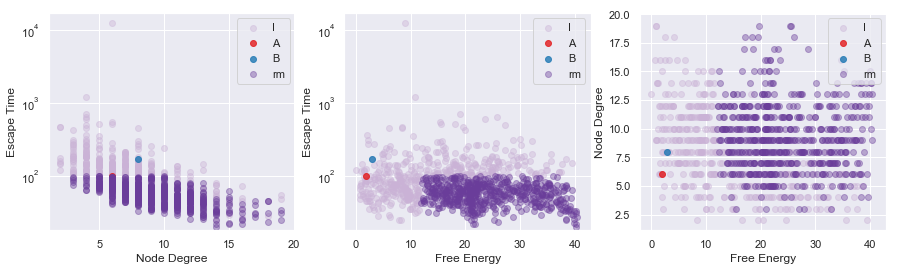

In [24]:
temp = 1.0
rank_nodes_to_eliminate(beta=1./temp, percent_retained=25, log=True)

Number of nodes with >1 connection: 994
A: 1, B: 1, I: 992


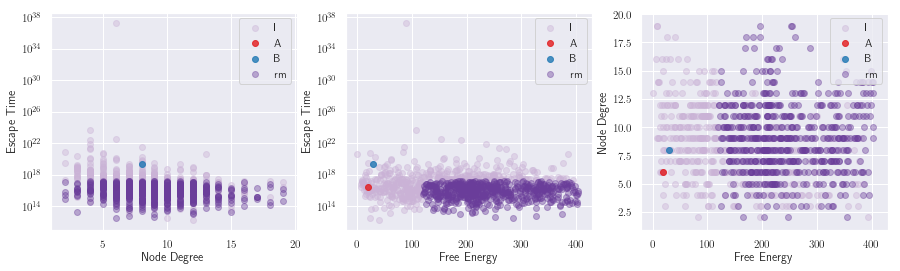

In [19]:
temp = 0.1
rank_nodes_to_eliminate(beta=1./temp, percent_retained=25, log=True)

### Compare hybrid nodes to transition path probabilities and committors

Both of these quantities can be calculated via kPS simulations, but are temperature dependent. So we'd have to re-run simulations at each temperature to use these quantities as heuristics for partial GT. However, it could provide a nice post-processing analysis to compare how partial GT heuristics measure up against these other quantities, which also demonstrate how A-->B dynamics are extremely localized.

In [6]:
data_path = Path("KTN_data/9state")
temp = 1.
beta = 1./temp
B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=True)
D = np.ravel(K.sum(axis=0)) 
#escape time
escape_times = 1./D
#free energy of minima
BF = beta*u-s
#rescaled
BF -= BF.min()
#node degree
node_degree = B.indptr[1:] - B.indptr[:-1]
# AB regions
#AS,BS = kio.load_AB(data_path,index_sel)
AS = np.zeros(N, bool)
BS = np.zeros(N, bool)
AS[Amin-1] = True
BS[Bmin-1] = True
IS = np.zeros(N, bool)
IS[~(AS+BS)] = True
print(f'Num in A: {AS.sum()}')
print(f'Num in B: {BS.sum()}')
print(f'Num in I: {IS.sum()}')
#committor AB
committor_AB = np.loadtxt(Path(data_path)/'committor_AB.dat')
committor_BA = np.loadtxt(Path(data_path)/'committor_BA.dat') #1 - committor_AB
tp_densities = np.loadtxt(Path(data_path)/'tp_densities.dat')


Connected Clusters: 1, 1st 400 states in largest cluster: 1
cc: N: 994->994 (994,) (994,)
Num in A: 1
Num in B: 1
Num in I: 992


In [21]:
def scatter_committors_tpd(beta = 1.0, rm_type='hybrid', percent_retained=10, 
                            log=False, escape_time_upper_bound=None):
    rm_reg = np.zeros(N,bool)
    #color nodes that we would propose to remove
    if rm_type == 'node_degree':
        rm_reg[node_degree < 2] = True
        rm_reg[(AS+BS)] = False #only remove the intermediate nodes this time

    if rm_type == 'escape_time':
        #remove nodes with the smallest escape times
        #retain nodes in the top percent_retained percentile of escape time
        rm_reg[IS] = escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained)

    if rm_type == 'free_energy':
        rm_reg[IS] = BF[IS] > np.percentile(BF[IS], percent_retained)

    if rm_type == 'combined':
        rho = np.exp(-BF)
        rho /= rho.sum()
        combo_metric = escape_times * rho
        rm_reg[IS] = combo_metric[IS] < np.percentile(combo_metric[IS], 100.0 - percent_retained)
        
    if rm_type == 'hybrid':
        #remove nodes in the top percent_retained percentile of escape time
        time_sel = (escape_times[IS] < np.percentile(escape_times[IS], 100.0 - percent_retained))
        bf_sel = (BF[IS]>np.percentile(BF[IS],percent_retained))
        sel = np.bitwise_and(time_sel, bf_sel)
        #that are also in the lowest percent_retained percentile of free energy
        rm_reg[IS] = sel
    fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(15,4))
    colors = sns.color_palette("Paired")
    #committor vs tp_density
    ax.scatter(committor_AB[~rm_reg], tp_densities[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax.scatter(committor_AB[AS], tp_densities[AS], color=colors[5], alpha=0.8, label='A')
    ax.scatter(committor_AB[BS], tp_densities[BS], color=colors[1], alpha=0.8, label='B')
    ax.scatter(committor_AB[rm_reg], tp_densities[rm_reg], color=colors[9], alpha=0.8, label='rm')
    ax.set_xlabel('Comittor AB')
    ax.set_ylabel('Transition path probability density')
    ax.legend()
    #tp_density vs escape time
    ax1.scatter(tp_densities[~rm_reg], escape_times[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax1.scatter(tp_densities[AS], escape_times[AS], color=colors[5], alpha=0.8, label='A')
    ax1.scatter(tp_densities[BS], escape_times[BS], color=colors[1], alpha=0.8, label='B')
    ax1.scatter(tp_densities[rm_reg], escape_times[rm_reg], color=colors[9], alpha=0.8, label='rm')
    ax1.set_xlabel('tp density')
    ax1.set_ylabel('Escape Time')
    if log:
        ax1.set_yscale('log')
    if escape_time_upper_bound is not None:
        ax.set_ylim([-1.0, escape_time_upper_bound])
    ax1.legend()
    #tp_density vs free energy
    ax2.scatter(BF[~rm_reg], tp_densities[~rm_reg], color=colors[8], alpha=0.4, label='I')
    ax2.scatter(BF[AS], tp_densities[AS], color=colors[5], alpha=0.8, label='A')
    ax2.scatter(BF[BS], tp_densities[BS], color=colors[1], alpha=0.8, label='B')
    ax2.scatter(BF[rm_reg], tp_densities[rm_reg], color=colors[9], alpha=0.8, label='rm')
    ax2.set_xlabel('Free Energy')
    ax2.set_ylabel('tp density')
    ax2.legend()
    plt.show()
    fig.tight_layout()

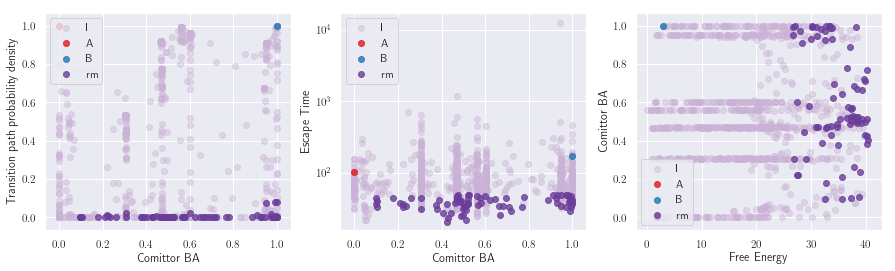

In [12]:
scatter_committors_tpd(percent_retained=75, log=True)

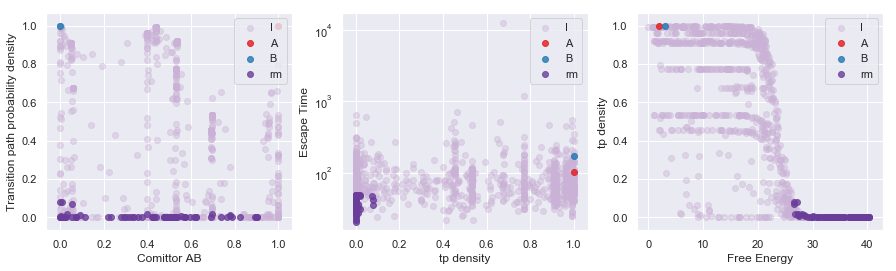

In [22]:
scatter_committors_tpd(percent_retained=75, log=True)

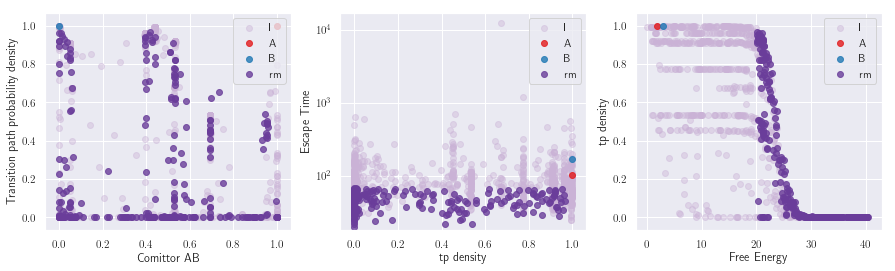

In [19]:
scatter_committors_tpd(percent_retained=50, log=True)

It does appear that the high-free-energy, short-lived states removed by the hybrid approach happen to have a small transition path probability density, which makes sense. It's also interesting to note that there's an exponential relationship between tpp density and free energy. So if we remove more than 25% of the nodes by free energy/escape time, we'll be removing nodes with a high tpp density.

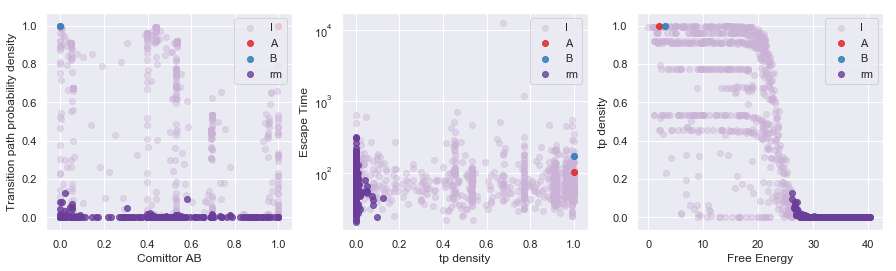

In [35]:
scatter_committors_tpd(percent_retained=75, rm_type='combined', log=True)

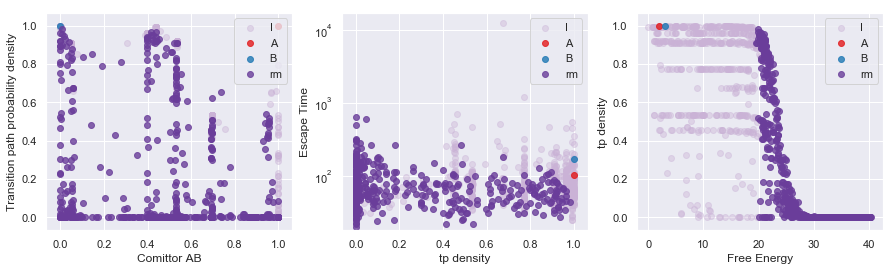

In [36]:
scatter_committors_tpd(percent_retained=50, rm_type='combined', log=True)

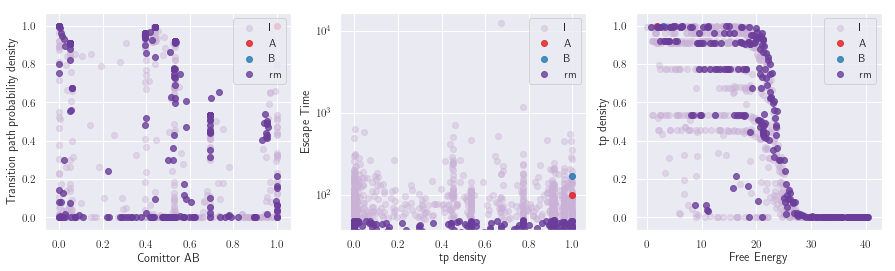

In [17]:
scatter_committors_tpd(percent_retained=75, rm_type = 'escape_time', log=True)

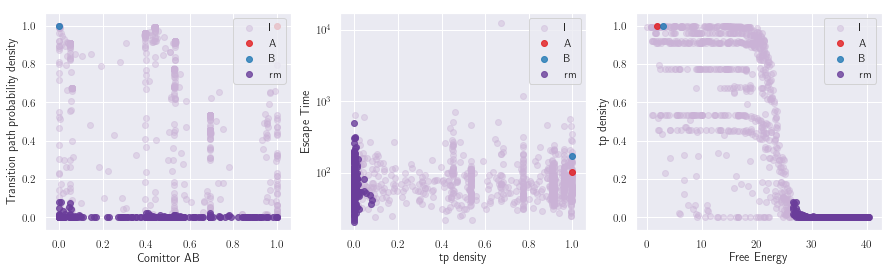

In [18]:
scatter_committors_tpd(percent_retained=75, rm_type = 'free_energy', log=True)

## Partial GT for A<->B first passage time distribution

In [30]:
# first re-make min.A and min.B files according to BACE community structure
def read_communities(commdat):
    """Read in a single column file called communities.dat where each line
    is the community ID (zero-indexed) of the minima given by the line
    numbenumber.

    Parameters
    ----------
    commdat : .dat file
        single-column file containing community IDs of each minimum

    Returns
    -------
    communities : dict
        mapping from community ID (1-indexed) to minima ID (1-indexed)
    """

    communities = {}
    with open(commdat, 'r') as f:
        for minID, line in enumerate(f, 1):
            groupID =  int(line) + 1
            if groupID in communities:
                communities[groupID].append(minID)
            else:
                communities[groupID] = [minID]
    for ci in communities:
        if Amin in communities[ci]:
            print(f"Community A: {ci}")
        if Bmin in communities[ci]:
            print(f"Community B: {ci}")
    return communities

In [32]:
communities_bace = read_communities(data_path/'communities_bace.dat')


Community B: 4
Community A: 8


In [33]:
commA = 8
commB = 4
with open(data_path/'min.A','w') as f:
    f.write(str(len(communities_bace[commA]))+'\n') #first line is number of minima
    for min in communities_bace[commA]:
        f.write(str(min)+'\n')

with open(data_path/'min.B','w') as f:
    f.write(str(len(communities_bace[commB]))+'\n') #first line is number of minima
    for min in communities_bace[commB]:
        f.write(str(min)+'\n')

In [2]:
def plot_AB_waiting_time(beta, rm_type='hybrid', percent_retained=10, data_path='KTN_data/9state', **kwargs):
    """ Plot two panels, A->B first passage time in full and reduced networks,
    and B->A first passage time in full and reduced networks. Reduce networks
    with three different heuristics (escape_time, free_energy, hybrid).
    """
    beta, tau, gttau, pt, gtpt = pgt.prune_intermediate_nodes(beta, dopdf=True, 
                            percent_retained=percent_retained, rm_type=rm_type, data_path=data_path, **kwargs)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    colors = sns.color_palette("bright", 10)
    names = ["A", "B"]
    for j in range(2):
        ax[j].set_title(r"%s$\to$%s (T=%2.2g)" % (names[j], names[1-j],1.0/beta))
        #full
        ax[j].plot(pt[2*j]/tau[2*j],pt[1+2*j],'-', color=colors[0], lw=2,
            label=r"Full $p_\mathcal{%s\to{%s}}(t)$" % (names[j],names[1-j]))
        #reduced
        ax[j].plot(gtpt[2*j]/gttau[2*j],gtpt[1+2*j],'-.',color=colors[1], lw=2,
            label=r"$p^{GT}_\mathcal{%s\to{%s}}(t)$, %s" % (names[j],names[1-j], rm_type))
        ax[j].set_xlabel(r"$t/\langle t \rangle$")
        if j==0:
            ax[j].set_ylabel(r"$\langle t \rangle p(t/\langle t \rangle)$")
        #if j==1:
        ax[j].legend()
        ax[j].set_xscale('log')
        ax[j].set_yscale('log')
        #ax[j].set_xlim(0.001,1000.)
        #ax[j].set_ylim(pt[1+2*j].min()/10.0,10.0)
    fig.tight_layout()

## T = 0.1

A: 98, B: 53, I: 843


/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:198: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:198: RuntimeWarning: overflow encountered in multiply
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:215: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:215: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()


Nodes to eliminate: 760
in A: 0, in B: 0, in I: 760


/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:198: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:198: RuntimeWarning: overflow encountered in multiply
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:215: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:215: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/miniconda3/lib/python3.6/site-packages/numpy/ma/core.py:6759: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


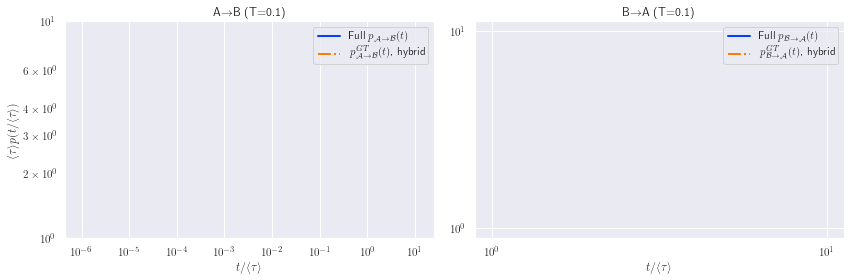

In [24]:
plot_AB_waiting_time(beta=1.0/0.1, rm_type='hybrid', percent_retained=5)

## T=1.0

A: 98, B: 53, I: 843
Nodes to eliminate: 760/994
in A: 0, in B: 0, in I: 760


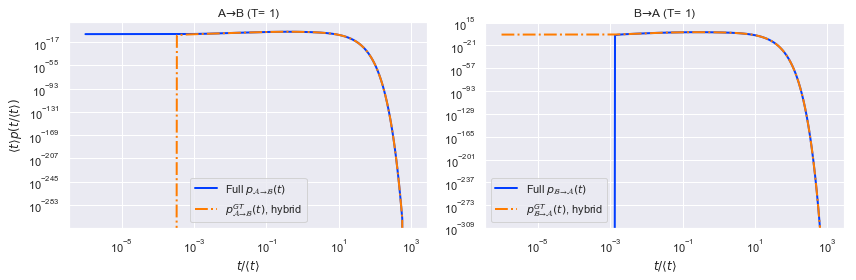

In [40]:
plot_AB_waiting_time(beta=1.0, rm_type='hybrid', percent_retained=5)

A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758


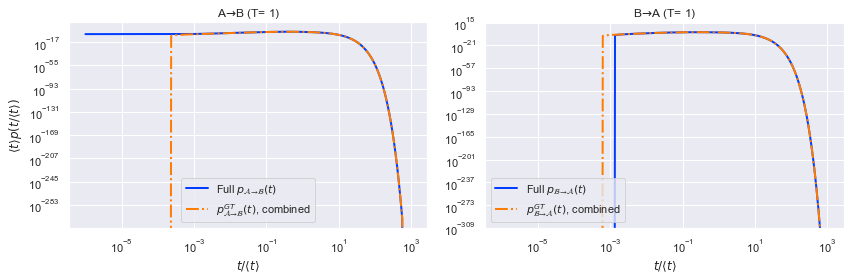

In [4]:
plot_AB_waiting_time(beta=1.0, rm_type='combined', percent_retained=10)

A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758


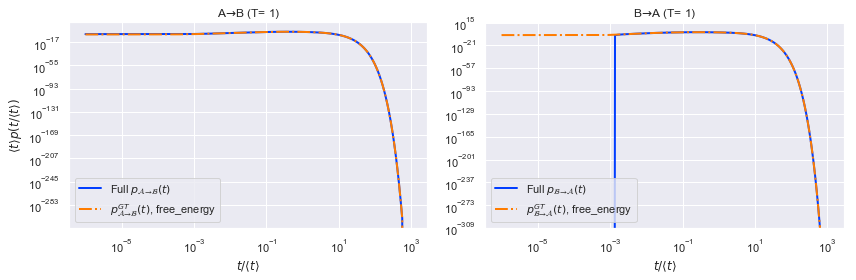

In [5]:
plot_AB_waiting_time(beta=1.0, rm_type='free_energy', percent_retained=10)

A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758


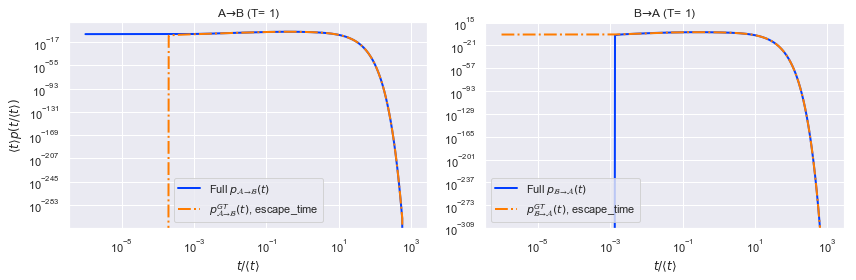

In [6]:
plot_AB_waiting_time(beta=1.0, rm_type='escape_time', percent_retained=10)

Eigendecomposition fails on the full network at T=0.1. At T= 1.0, eigendecomposition fails to get the short-time distribution in B -> A direction at low temperatures. In all three GT-reduced networks, the eigendecomposition is possible in the reduced networks. However, in A->B direction, removing by escape time or by hybrid approach makes eigendecomposition fail in the reduced network even though it's possible in the full network. Does this mean that removing short-lived states makes the GT-reduced matrix more ill-conditioned?

## T = 10

A: 98, B: 53, I: 843
Nodes to eliminate: 590
in A: 0, in B: 0, in I: 590


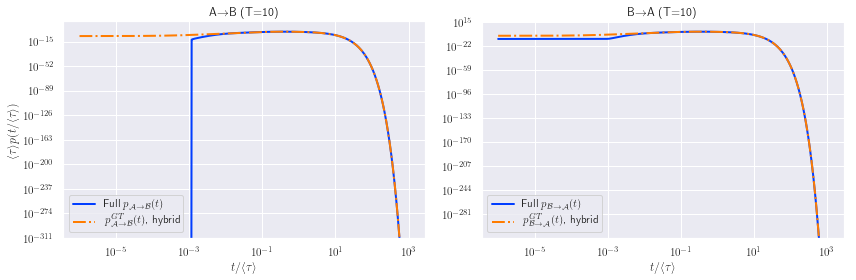

In [27]:
plot_AB_waiting_time(beta=1.0/10., rm_type='escape_time', percent_retained=30)

A: 98, B: 53, I: 843
Nodes to eliminate: 590
in A: 0, in B: 0, in I: 590


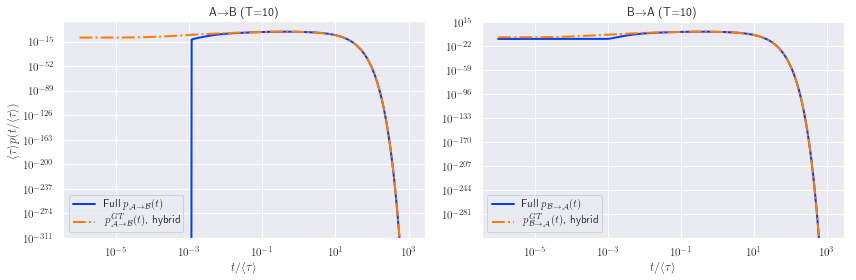

In [26]:
plot_AB_waiting_time(beta=1.0/10., rm_type='free_energy', percent_retained=30)

A: 98, B: 53, I: 843
Nodes to eliminate: 590/994
in A: 0, in B: 0, in I: 590


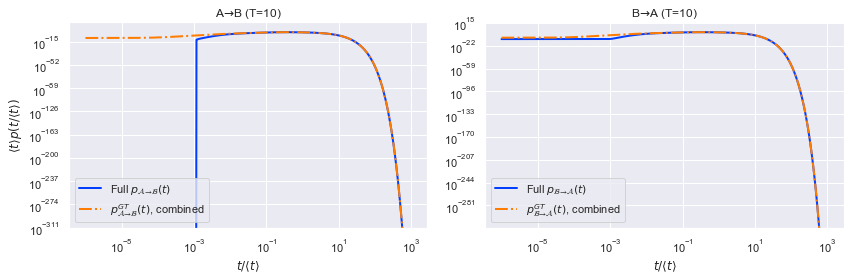

In [7]:
plot_AB_waiting_time(beta=1.0/10., rm_type='combined', percent_retained=30)

A: 98, B: 53, I: 843
Nodes to eliminate: 607
in A: 0, in B: 0, in I: 607


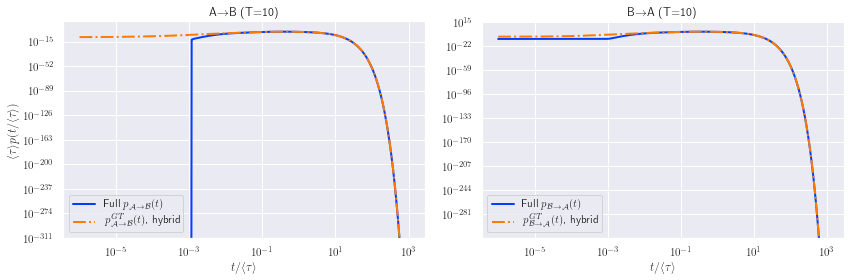

In [28]:
plot_AB_waiting_time(beta=1.0/10., rm_type='hybrid', percent_retained=15)

## T=20

A: 98, B: 53, I: 843
Nodes to eliminate: 590
in A: 0, in B: 0, in I: 590


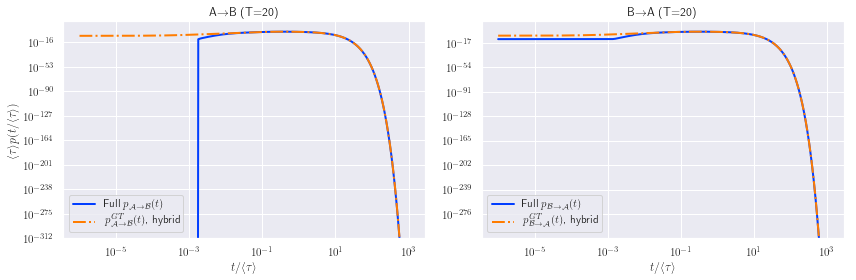

In [30]:
plot_AB_waiting_time(beta=1.0/20., rm_type='escape_time', percent_retained=30)

## Compute mean and variance of FPT distribution

In [11]:
def plot_AB_fpt_moments_vs_temperature(betas, rm_type='hybrid', percent_retained=10, data_path='KTN_data/9state/'):
    data = np.zeros((9, len(betas)))
    for i, beta in enumerate(betas):
        data[0,i], data[1:5,i], data[5:9,i] = pgt.prune_intermediate_nodes(beta, dopdf=False, rm_type=rm_type,
                                                        percent_retained=percent_retained, data_path=data_path, screen=False)
    fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=120,sharey=True)
    for j in range(2):
        names=['A','B']
        size = [98, 53]
        ax[j].set_title(r"%s$\to$%s (from %d$\to$%d states)" % (names[j],names[1-j],size[j],size[1-j]))
        #full
        ax[j].plot(data[0,:],data[1+2*j,:],'C0-',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
        ax[j].plot(data[0,:],np.sqrt(data[2+2*j,:]-data[1+2*j,:]**2),'C2-.',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$" % (names[j],names[1-j]))
        #reduced
        ax[j].plot(data[0,:],data[5+2*j,],'C1--',lw=3,label=r"$\langle\tau\rangle_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
        ax[j].plot(data[0,:],np.sqrt(data[6+2*j,:]-data[5+2*j,:]**2),'C3--',lw=3,label=r"$\sigma_\mathcal{%s\to{%s}}$ (GT)" % (names[j],names[1-j]))
        ax[j].set_xlabel(r"$1/T$")
        if j==0:
            ax[j].set_ylabel("Time")
        ax[j].legend()
        ax[j].set_yscale("log")
    fig.tight_layout()
        

/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: overflow encountered in multiply
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: invalid v

/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: invalid value encountered in matmul
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: invalid value encountered in matmul
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: divide by zero encountered in true_divide
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeW

/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: invalid value encountered in matmul
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: overflow encountered in exp
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:132: RuntimeWarning: overflow encountered in multiply
  pt[3] = (v*w*nu)@np.exp(-np.outer(nu,pt[2]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: overflow encountered in exp
  pt[1] = (v*w*nu)@np.exp(-np.outer(nu,pt[0]))*(v*w/nu).sum()
/Users/deepti/Documents/Wales/git-remotes/tom_KTN/lib/partialGT.py:115: RuntimeWarning: invalid v

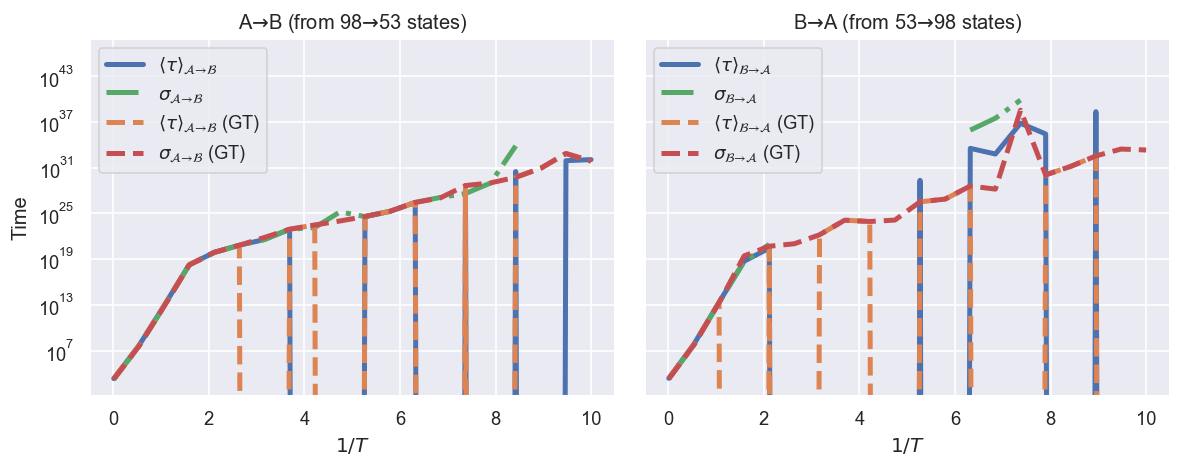

In [12]:
plot_AB_fpt_moments_vs_temperature(betas=np.linspace(0.01, 10., 20))

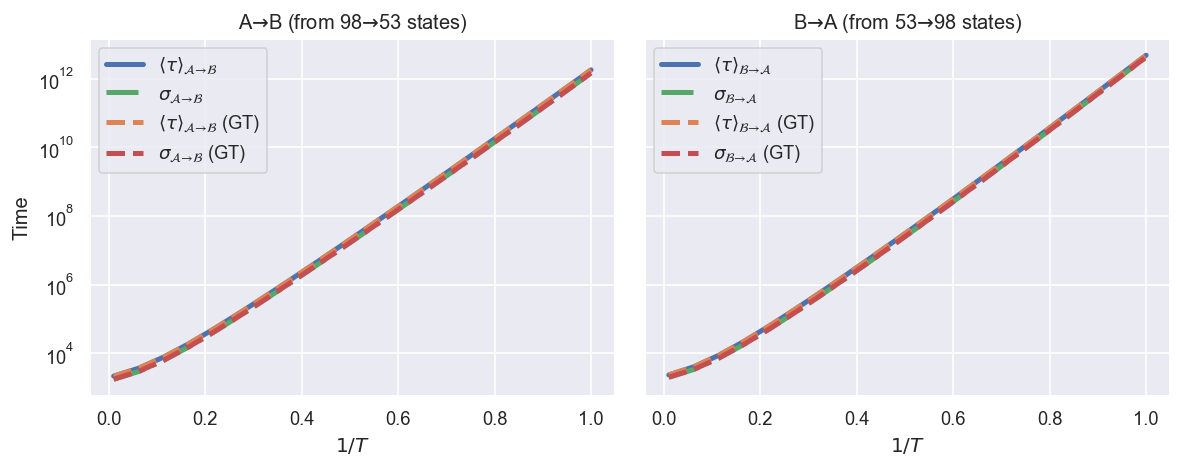

In [13]:
plot_AB_fpt_moments_vs_temperature(betas=np.linspace(0.01, 1., 20), rm_type='hybrid')

A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758
A: 98, B: 53, I: 843
Nodes to eliminate: 758/994
in A: 0, in B: 0, in I: 758

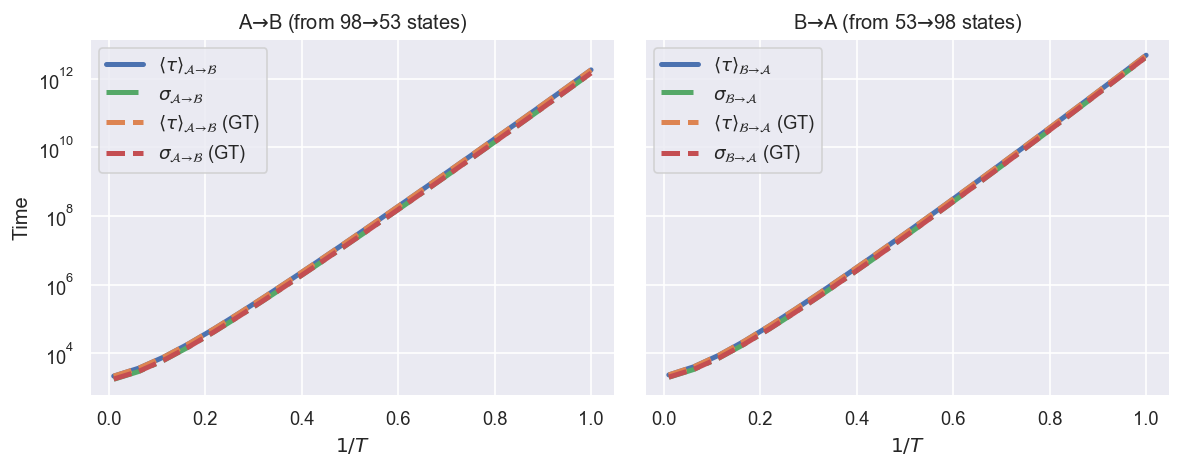

In [9]:
plot_AB_fpt_moments_vs_temperature(betas=np.linspace(0.01, 1., 20), rm_type='combined')

## Partial GT for Basin Escape

In [2]:
def prune_basins(beta, percent_retained_in_B, rm_type, 
                 data_path=Path('KTN_data/9state'), dopdf=True):
    """ Prune each basin and plot the full PT vs reduced PT."""
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    communities = pgt.read_communities(data_path/'communities_bace.dat', index_sel)
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    for j in communities:
        beta, tau, gttau, pt, gtpt = pgt.prune_source(beta, BS=communities[j], 
                                                      percent_retained_in_B=percent_retained_in_B,
                                                      rm_type=rm_type, data_path=data_path, dopdf=dopdf)
        ax = axes[int(j/4)][j%4]
        ax.set_title(f"Escape from {j}, T={(1.0/beta):.2f}")
        names=["AUI","B"]
        ax.plot(pt[0]/tau[0],pt[1],'C0-',lw=2,label=r"Full $P(\tau)$")
        ax.plot(gtpt[0]/tau[0],gtpt[1],'C1-.',lw=2,label=r"$P^{GT}(\tau)$")
        ax.legend()
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlim(0.001,1000.)
        if j==2:
            ax.set_xlabel(r"$t/\langle t \rangle$")
        if j%4 == 0:
            ax.set_ylabel(r"$\langle t \rangle p(t/\langle t \rangle)$")
        #ax.set_ylim(pt[1].min()/10.0,100.0)
    plt.tight_layout()
        

## T=10

Community 0: 112
Community 1: 130
Community 2: 89
Community 3: 53
Community 4: 110
Community 5: 77
Community 6: 132
Community 7: 98
Community 8: 102
Community 9: 54
Community 10: 37
Nodes to eliminate: 93
Nodes to eliminate: 54
Nodes to eliminate: 80
Nodes to eliminate: 61
Nodes to eliminate: 72
Nodes to eliminate: 37
Nodes to eliminate: 40
Nodes to eliminate: 91
Nodes to eliminate: 78
Nodes to eliminate: 69
Nodes to eliminate: 27


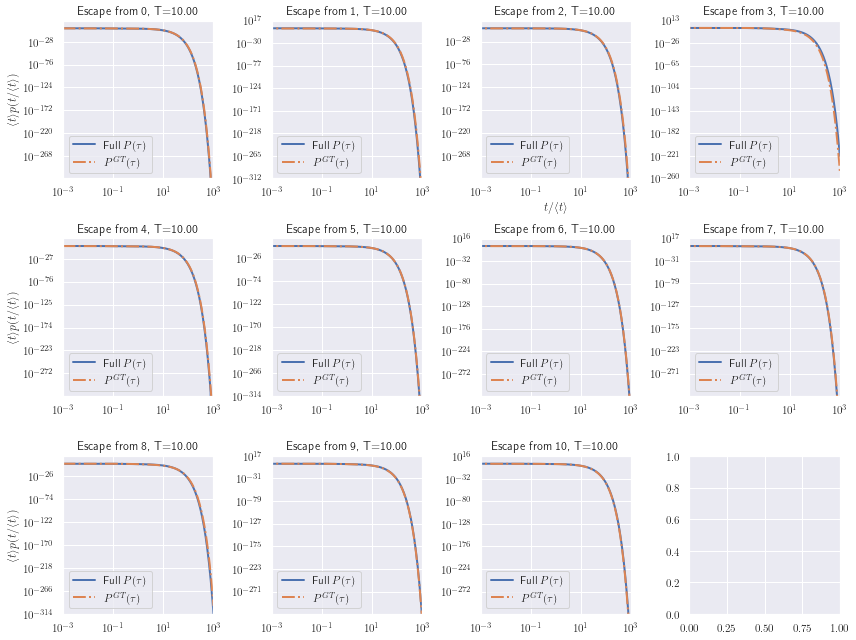

In [18]:
prune_basins(beta=1.0/10, percent_retained_in_B=15, rm_type='hybrid')

Community 0: 112
Community 1: 130
Community 2: 89
Community 3: 53
Community 4: 110
Community 5: 77
Community 6: 132
Community 7: 98
Community 8: 102
Community 9: 54
Community 10: 37
Nodes to eliminate: 99
Nodes to eliminate: 57
Nodes to eliminate: 82
Nodes to eliminate: 66
Nodes to eliminate: 76
Nodes to eliminate: 39
Nodes to eliminate: 40
Nodes to eliminate: 97
Nodes to eliminate: 84
Nodes to eliminate: 73
Nodes to eliminate: 27


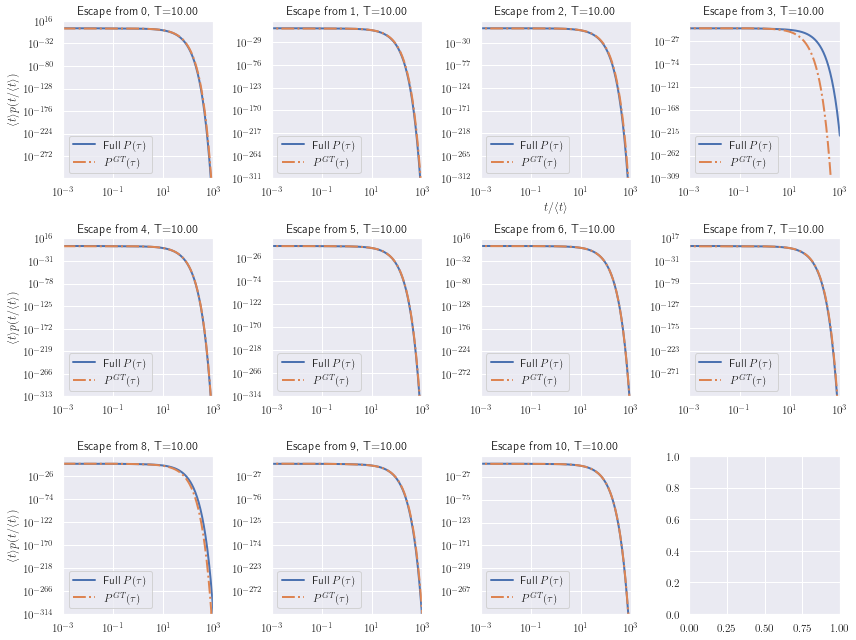

In [19]:
prune_basins(beta=1.0/10, percent_retained_in_B=25, rm_type='free_energy')

Community 0: 112
Community 1: 130
Community 2: 89
Community 3: 53
Community 4: 110
Community 5: 77
Community 6: 132
Community 7: 98
Community 8: 102
Community 9: 54
Community 10: 37
Nodes to eliminate: 99
Nodes to eliminate: 57
Nodes to eliminate: 82
Nodes to eliminate: 66
Nodes to eliminate: 76
Nodes to eliminate: 39
Nodes to eliminate: 40
Nodes to eliminate: 97
Nodes to eliminate: 84
Nodes to eliminate: 73
Nodes to eliminate: 27


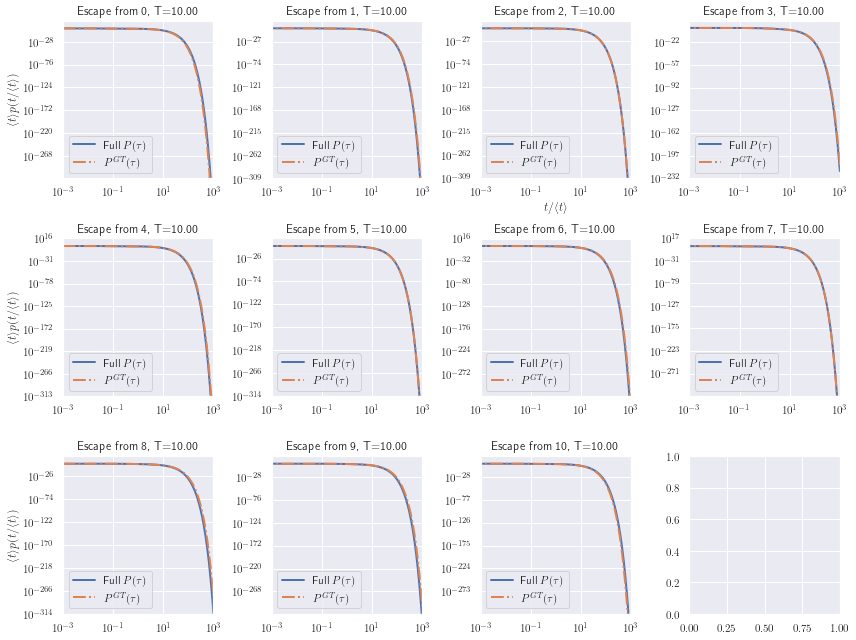

In [20]:
prune_basins(beta=1.0/10, percent_retained_in_B=25, rm_type='escape_time')

## T=1.0

Nodes to eliminate: 118
Nodes to eliminate: 69
Nodes to eliminate: 99
Nodes to eliminate: 79
Nodes to eliminate: 91
Nodes to eliminate: 48
Nodes to eliminate: 48
Nodes to eliminate: 116
Nodes to eliminate: 100
Nodes to eliminate: 88
Nodes to eliminate: 34


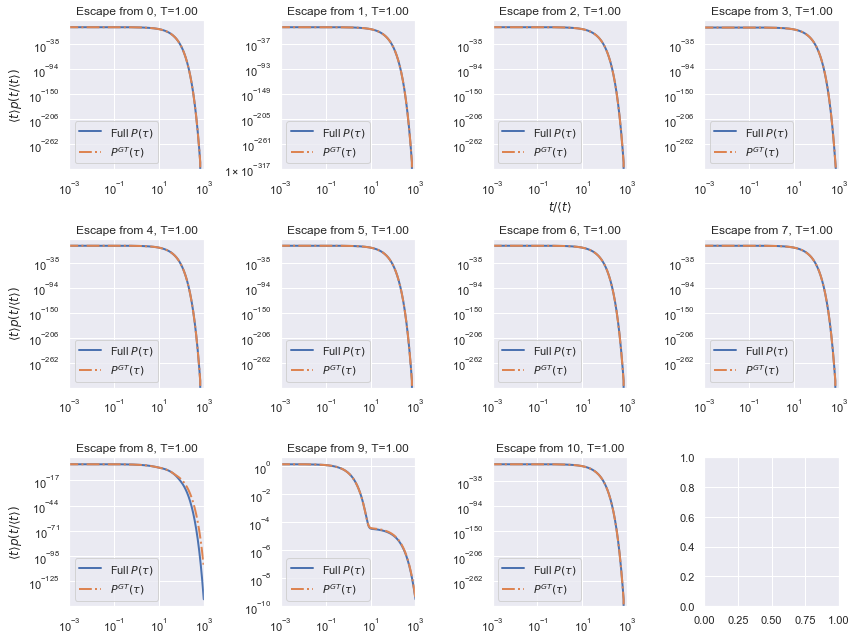

In [6]:
prune_basins(beta=1.0, percent_retained_in_B=5, rm_type='hybrid')

Nodes to eliminate: 118
Nodes to eliminate: 69
Nodes to eliminate: 99
Nodes to eliminate: 80
Nodes to eliminate: 91
Nodes to eliminate: 47
Nodes to eliminate: 48
Nodes to eliminate: 117
Nodes to eliminate: 100
Nodes to eliminate: 88
Nodes to eliminate: 33


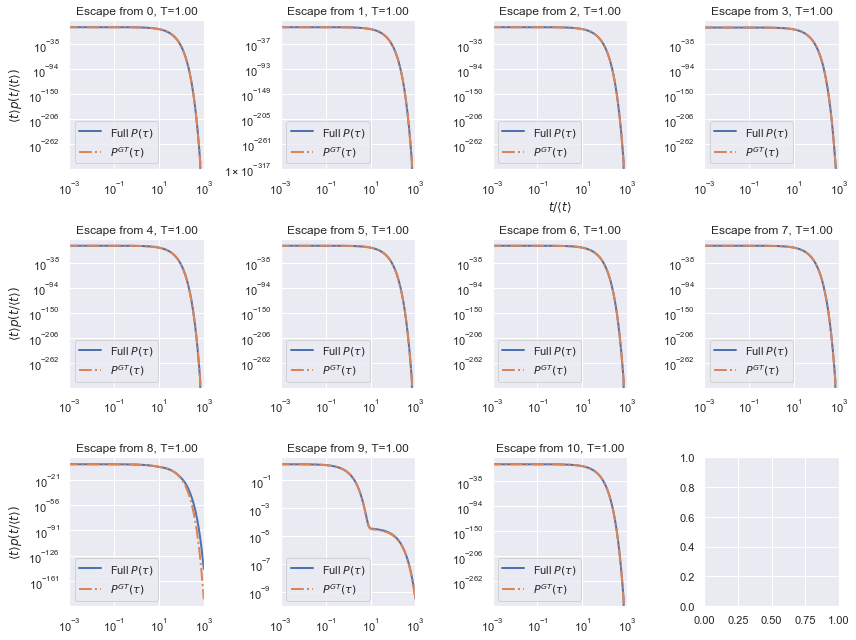

In [4]:
prune_basins(beta=1.0, percent_retained_in_B=10, rm_type='free_energy')

Nodes to eliminate: 118
Nodes to eliminate: 69
Nodes to eliminate: 99
Nodes to eliminate: 80
Nodes to eliminate: 91
Nodes to eliminate: 47
Nodes to eliminate: 48
Nodes to eliminate: 117
Nodes to eliminate: 100
Nodes to eliminate: 88
Nodes to eliminate: 33


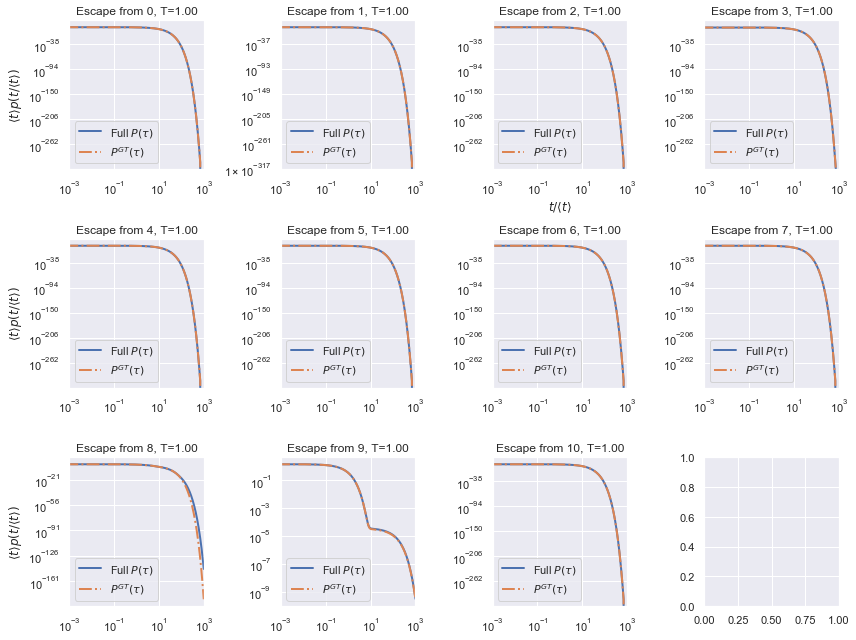

In [3]:
prune_basins(beta=1.0, percent_retained_in_B=10, rm_type='combined')

Nodes to eliminate: 118
Nodes to eliminate: 69
Nodes to eliminate: 99
Nodes to eliminate: 80
Nodes to eliminate: 91
Nodes to eliminate: 47
Nodes to eliminate: 48
Nodes to eliminate: 117
Nodes to eliminate: 100
Nodes to eliminate: 88
Nodes to eliminate: 33


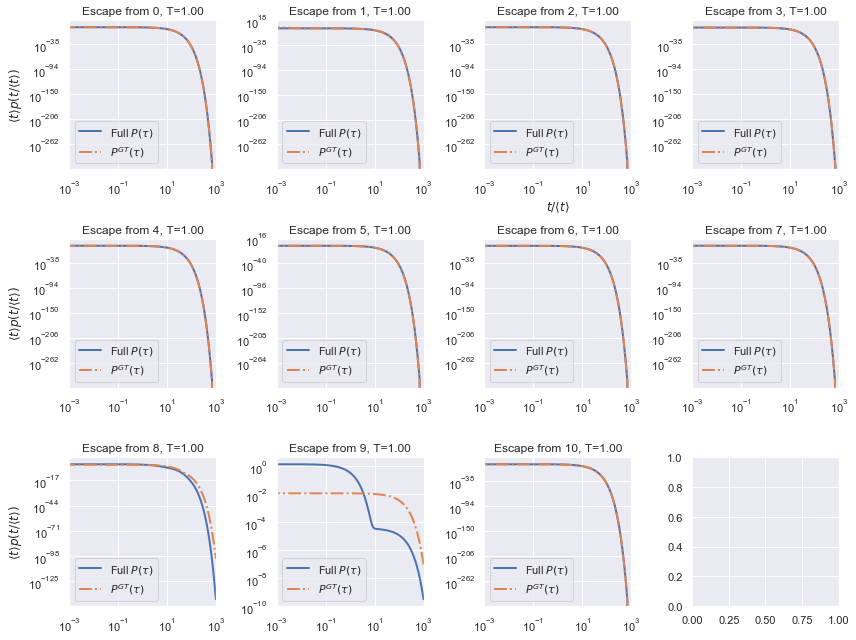

In [5]:
prune_basins(beta=1.0, percent_retained_in_B=10, rm_type='escape_time')

## Low temperature calculations

Community 0: 112
Community 1: 130
Community 2: 89
Community 3: 53
Community 4: 110
Community 5: 77
Community 6: 132
Community 7: 98
Community 8: 102
Community 9: 54
Community 10: 37
Nodes to eliminate: 93
Nodes to eliminate: 58
Nodes to eliminate: 83
Nodes to eliminate: 62
Nodes to eliminate: 73
Nodes to eliminate: 40
Nodes to eliminate: 40
Nodes to eliminate: 92
Nodes to eliminate: 81
Nodes to eliminate: 69
Nodes to eliminate: 29


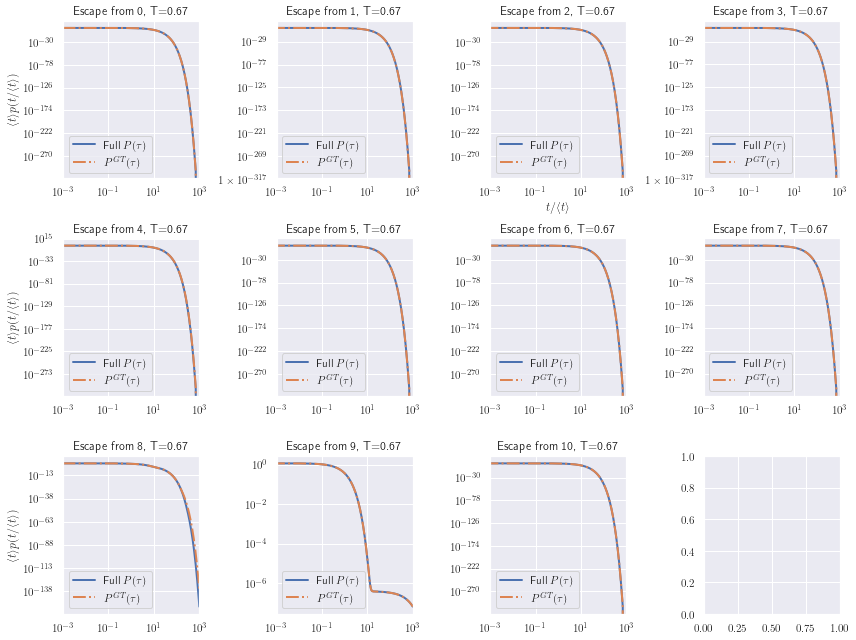

In [26]:
prune_basins(beta=1.5, percent_retained_in_B=15, rm_type='hybrid')

## Sequential GT on Basins

Reduce each basin and feed the reduced network into the next round of GT, until each basin only retains 25% of it's states, resulting in a reduced network that is 1/4 its original size.

### T=1, conservatively REMOVING roughly 25% of the nodes

In [2]:
def compare_basins(beta, r_BF, r_Q, r_comms, data_path=Path('KTN_data/9state'), dopdf=True):
    """ Compare basin escape time distribution in network where all basins have been 
    pruned to the original network."""
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    communities = pgt.read_communities(data_path/'communities_bace.dat', index_sel)
    D = np.ravel(K.sum(axis=0))
    escape_time = 1./D
    Q = diags(D)-K
    BF = beta*u-s
    BF -= BF.min()
    fig, axes = plt.subplots(3, 4, figsize=(14, 9))
    for j in communities:
        tau, pt = pgt.compute_escape_stats(communities[j], BF, Q, dopdf=True)
        gttau, gtpt = pgt.compute_escape_stats(r_comms[j], r_BF, r_Q,
                                       tau_escape=tau[0], dopdf=True)
        ax = axes[int(j/4)][j%4]
        ax.set_title(f"Escape from {j}, T={(1.0/beta):.2f}")
        names=["AUI","B"]
        ax.plot(pt[0]/tau[0],pt[1],'C0-',lw=2,label=r"Full $P(\tau)$")
        ax.plot(gtpt[0]/tau[0],gtpt[1],'C1-.',lw=2,label=r"$P^{GT}(\tau)$")
        ax.legend()
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_xlim(0.001,1000.)
        if j==2:
            ax.set_xlabel(r"$t/\langle t \rangle$")
        if j%4 == 0:
            ax.set_ylabel(r"$\langle t \rangle p(t/\langle t \rangle)$")
        #ax.set_ylim(pt[1].min()/10.0,100.0)
    fig.tight_layout()

In [39]:
from matplotlib.colors import LogNorm
#calculate ratio of MFPT in reduced network to full network for all pairs of communities
#same for the second moment
def get_first_second_moment_ratios_reduced_full(beta, r_BF, r_Q, r_comms, data_path=Path('KTN_data/9state'),
                                               log=False):
    #first compute c1<->c2 passage time distributions on full network
    B, K, D, N, u, s, Emin, index_sel = kio.load_mat(path=data_path,beta=beta,Emax=None,Nmax=None,screen=False)
    D = np.ravel(K.sum(axis=0))
    Q = diags(D)-K
    BF = beta*u-s
    BF -= BF.min()
    communities = pgt.read_communities(data_path/'communities.dat', index_sel)
    ncomms = len(communities)
    #i <- j <tau> and <tau^2> ratios for reduced/full
    mfpt_mat = np.ones((ncomms, ncomms))
    std_mat = np.ones((ncomms, ncomms))
    for c1 in communities:
        for c2 in communities:
            if c1 < c2:
                #update matrices
                tau_full = pgt.compute_passage_stats(communities[c1], communities[c2], BF, Q, dopdf=False)
                #now compute c1<->c2 passage time distributions on reduced network
                tau = pgt.compute_passage_stats(r_comms[c1], r_comms[c2], r_BF, 
                                                r_Q, dopdf=False)
                #c2 <- c1
                mfpt_mat[c2][c1] = tau[0]/tau_full[0]
                std_mat[c2][c1] = tau[1]/tau_full[1]
                #c1 <-c2
                mfpt_mat[c1][c2] = tau[2]/tau_full[2]
                std_mat[c1][c2] = tau[3]/tau_full[3]
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8,4))
    if log:
        sns.heatmap(mfpt_mat, center=1.0, annot=False, cmap='RdYlBu', 
                    norm=LogNorm(mfpt_mat.min(), mfpt_mat.max()), 
                    cbar_kws={"ticks":[0,1,10,1e2,1e3]}, ax=ax0)
        sns.heatmap(std_mat, center=1.0, annot=False, cmap='RdYlBu', 
                    norm=LogNorm(std_mat.min(), std_mat.max()), 
                    cbar_kws={"ticks":[0,1,10,1e2,1e3,1e4,1e5]}, ax=ax1)
    else:
        sns.heatmap(mfpt_mat, center=1.0, annot=True, cmap='RdYlBu', ax=ax0)
        sns.heatmap(std_mat, center=1.0, annot=True, cmap='RdYlBu', ax=ax1)
    ax0.set_title('MFPT GT/full')
    ax1.set_title(r'$\sigma$ GT/full')
    fig.tight_layout()
    return mfpt_mat, std_mat

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 27.272727272727273
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 28.571428571428573
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 23.636363636363637
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 20.224719101123597
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 28.431372549019606
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 28.30188679245283
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 22.22222222222222
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 20.0
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 21.428571428571427
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 23.46938775510204
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 35.13513513513514
Removed 244 of 994 nodes, retained 75.45271629778672 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


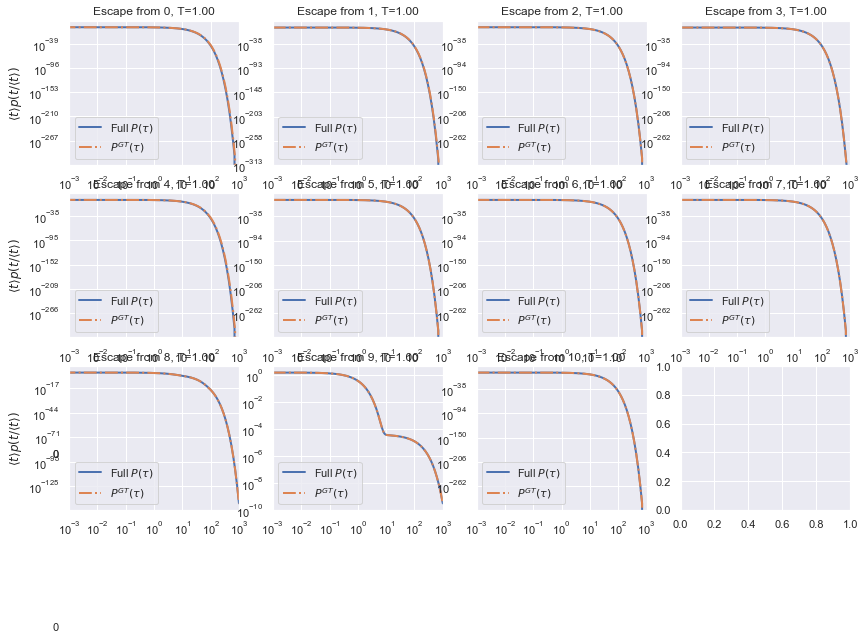

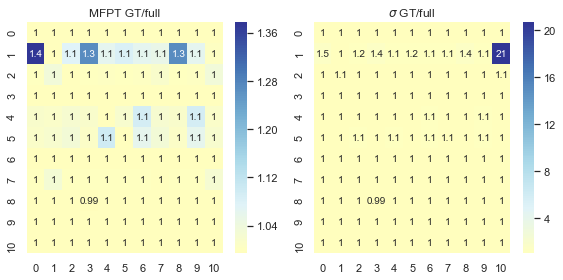

In [41]:
#start by conservatively removing 25% of the nodes at T=1
#recall, that these nodes do not have a high tpp density
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='hybrid', percent_retained=53)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* Seems like passage times to basin 1 are a bit off, especially the variance of the 10 -> 1 fpt distribution
* community 1 is not A or B

In [7]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='free_energy', percent_retained=75)

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 25.0
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 24.675324675324674
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 25.454545454545453
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 24.719101123595507
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 25.49019607843137
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 24.528301886792452
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 25.925925925925927
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 25.384615384615383
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 25.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 25.510204081632654
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 24.324324324324323
Removed 250 of 994 nodes, retained 74.84909456740442 percent


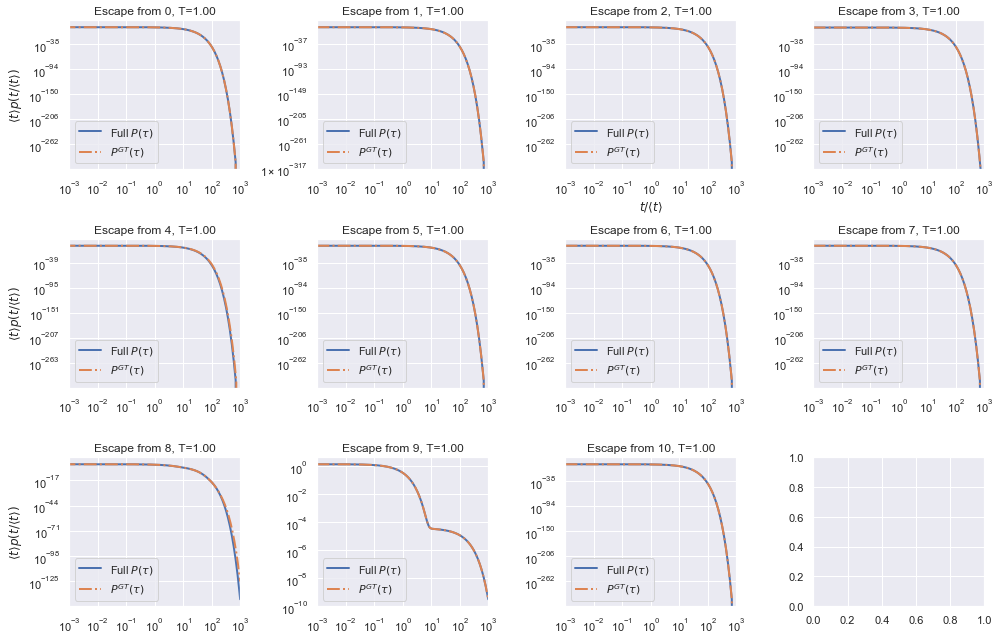

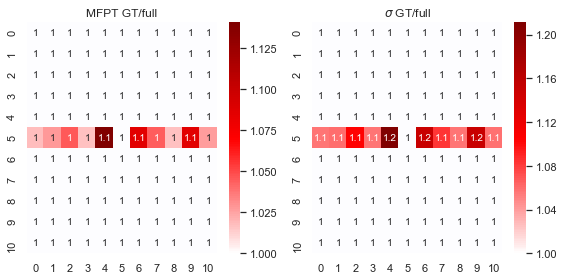

In [8]:
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* Interestingly, removing nodes by free energy works even better than the hybrid heuristic. Max error of 1.2.
* In this case, passage stats to basin 5 are the most erroneous. Why is it that theres always one basin that suffers?

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 25.0
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 24.675324675324674
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 25.454545454545453
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 24.719101123595507
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 25.49019607843137
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 24.528301886792452
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 25.925925925925927
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 25.384615384615383
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 25.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 25.510204081632654
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 24.324324324324323
Removed 250 of 994 nodes, retained 74.84909456740442 percent


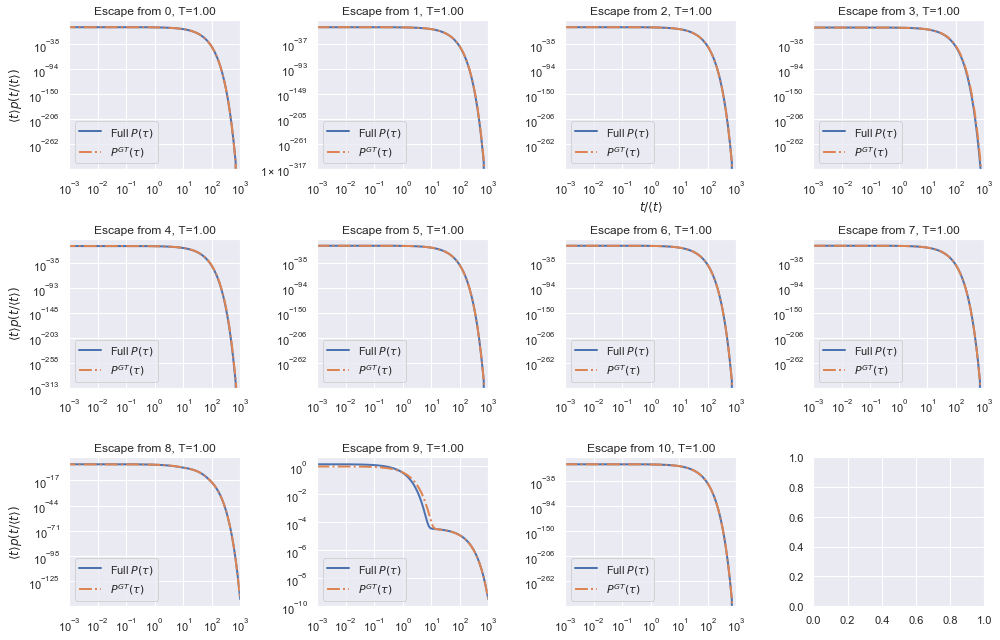

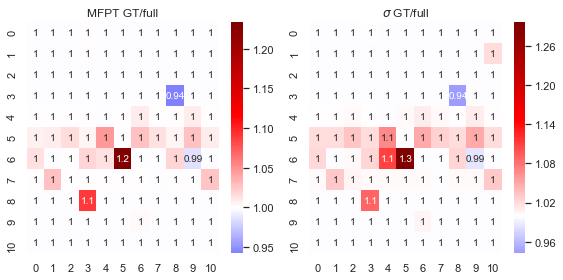

In [9]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='escape_time', percent_retained=75)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* Perhaps escape_time wins? max error is 1.3, and thats only for a specific pair of communities. I don't even see one row being entirely erroneous like was the case for the 'hybrid' and 'free_energy' approach.
* Almost all ci<->cj means and varriances are equivalent in reduced and full network!

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 25.0
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 24.675324675324674
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 25.454545454545453
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 24.719101123595507
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 25.49019607843137
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 24.528301886792452
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 25.925925925925927
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 25.384615384615383
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 25.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 25.510204081632654
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 24.324324324324323
Removed 250 of 994 nodes, retained 74.84909456740442 percent


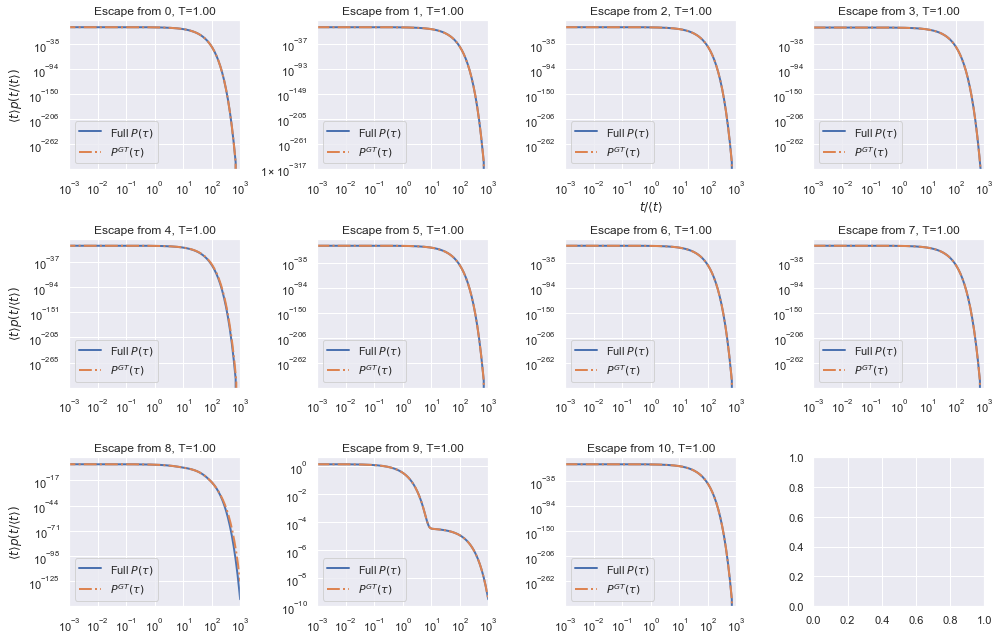

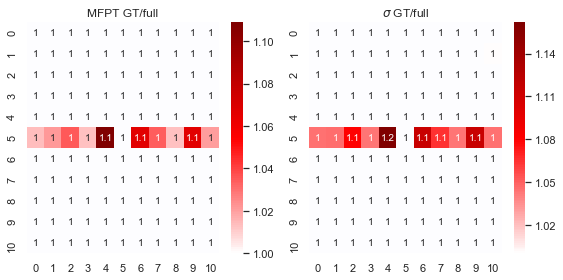

In [10]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='combined', percent_retained=75)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* New, combined heuristic definitely wins on all fronts!

### T=1, this time RETAINING about 25%

In [42]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='hybrid', percent_retained=13)

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 73.48484848484848
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 79.22077922077922
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 78.18181818181819
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 73.03370786516854
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 75.49019607843137
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 79.24528301886792
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 77.77777777777777
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 73.84615384615384
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 81.08108108108108
Removed 753 of 994 nodes, retained 24.24547283702213 percent


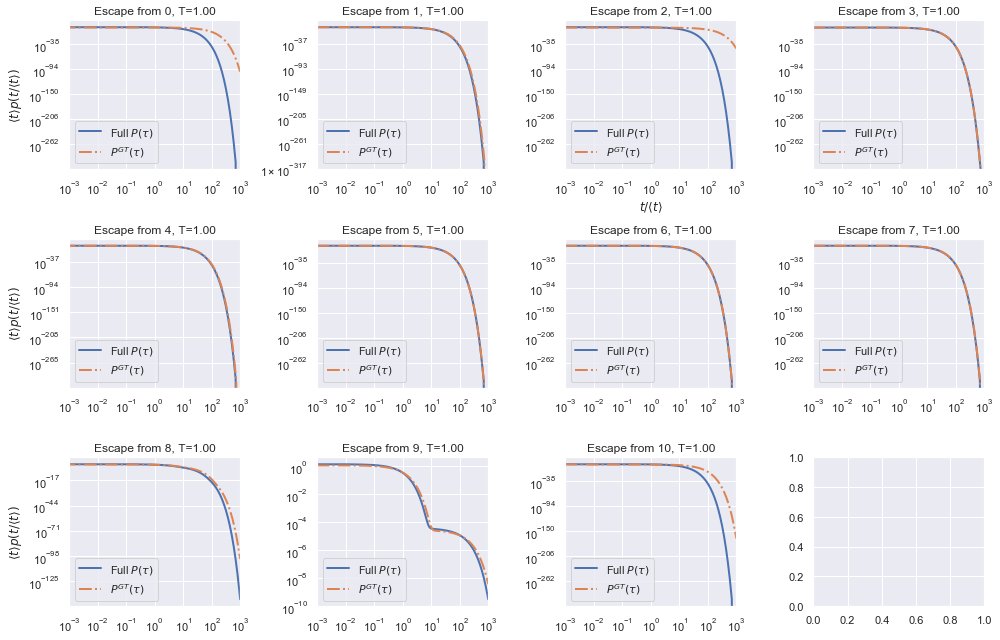

In [26]:
compare_basins(1.0, r_BF, r_Q, r_communities)

Now we start to see pretty significant errors in the escape time distributions from reduced basins 0, 2, 8, 10

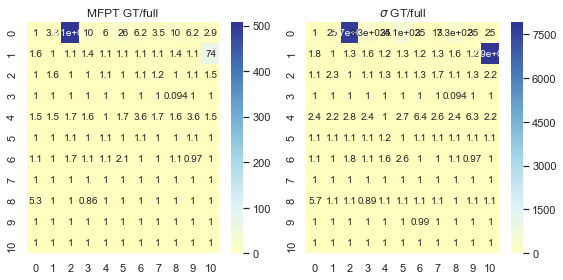

In [43]:
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities, log=False)

In [16]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='free_energy', percent_retained=25)

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 75.0
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 74.02597402597402
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 74.54545454545455
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 74.15730337078652
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 74.50980392156863
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 73.58490566037736
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 74.07407407407408
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 74.61538461538461
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 72.97297297297297
Removed 740 of 994 nodes, retained 25.553319919517104 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


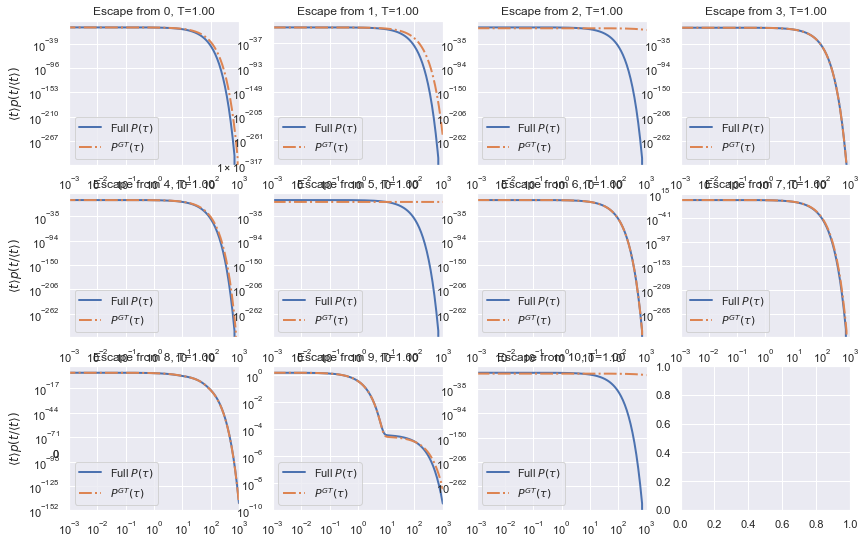

In [17]:
compare_basins(1.0, r_BF, r_Q, r_communities)

* If we use free energy to remove nodes instead of the hybrid approach, we also have errors, but in different communities.
* In this reduced network, the escape distribution from basins 1, 2, 5, and 10 are significantly off.

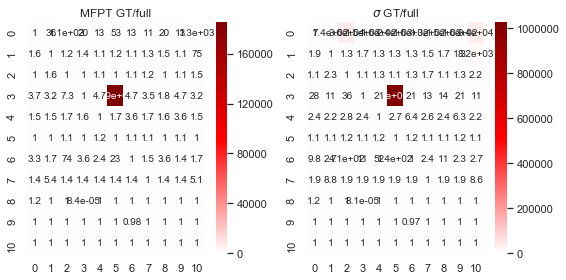

In [18]:
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 75.0
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 74.02597402597402
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 74.54545454545455
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 74.15730337078652
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 74.50980392156863
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 73.58490566037736
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 74.07407407407408
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 74.61538461538461
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 72.97297297297297
Removed 740 of 994 nodes, retained 25.553319919517104 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


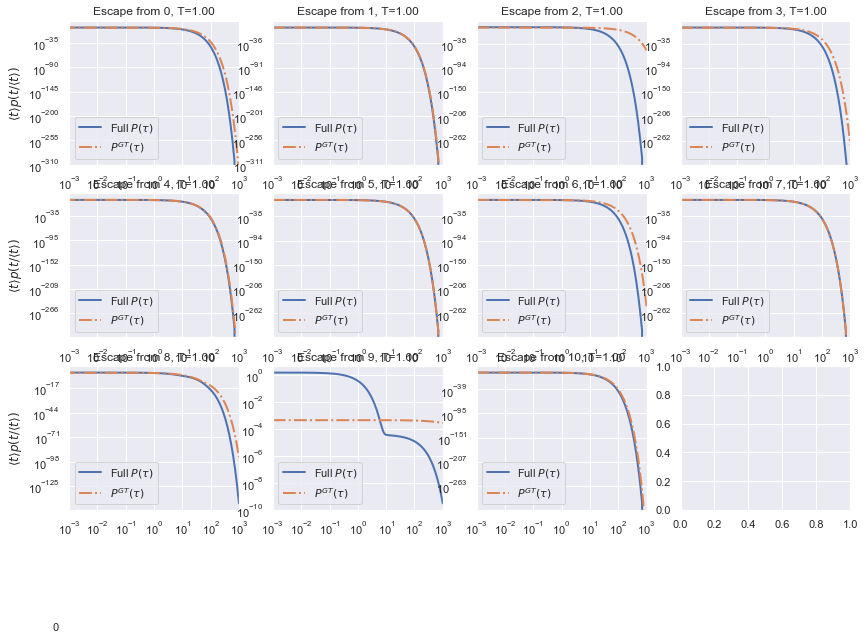

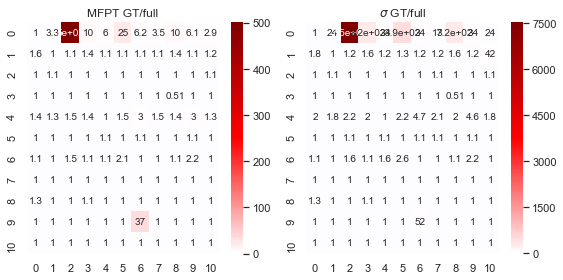

In [19]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='escape_time', percent_retained=25)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* So the escape_time heuristic gets some of the escape time distributions wrong, especially from basin 9.
* But it does well on the community <-> community passage time stats, with a few specific exceptions.
* In contrast, removing by 'free_energy' or by 'hybrid' approach leads to several orders of magnitude of error for passage time stats between many pairs of communities

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 75.0
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 74.02597402597402
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 74.54545454545455
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 74.15730337078652
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 74.50980392156863
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 73.58490566037736
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 74.07407407407408
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 74.61538461538461
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 75.0
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 74.48979591836735
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 72.97297297297297
Removed 740 of 994 nodes, retained 25.553319919517104 percent


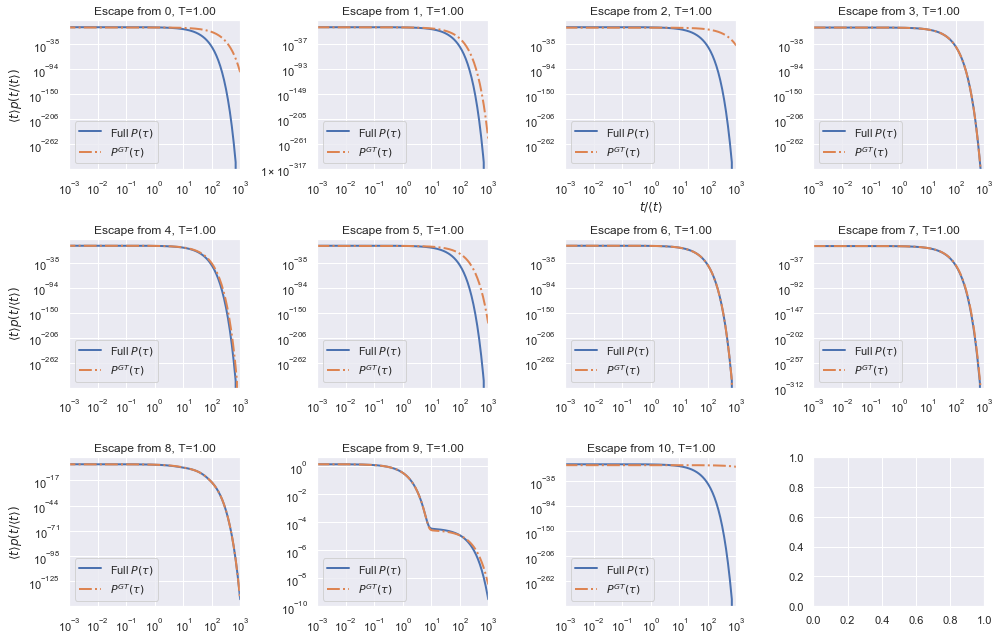

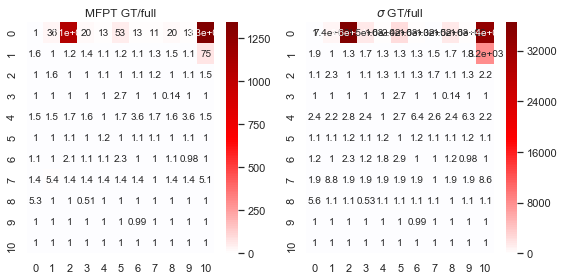

In [20]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='combined', percent_retained=25)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

### T=1, this time RETAINING about 50%

In [21]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                               rm_type='hybrid', percent_retained=30)

Source comm: 6, Source nodes: 132
Percent eliminated from basin: 49.24242424242424
Source comm: 5, Source nodes: 77
Percent eliminated from basin: 54.54545454545455
Source comm: 4, Source nodes: 110
Percent eliminated from basin: 53.63636363636363
Source comm: 2, Source nodes: 89
Percent eliminated from basin: 46.06741573033708
Source comm: 8, Source nodes: 102
Percent eliminated from basin: 52.94117647058823
Source comm: 3, Source nodes: 53
Percent eliminated from basin: 52.83018867924528
Source comm: 9, Source nodes: 54
Percent eliminated from basin: 50.0
Source comm: 1, Source nodes: 130
Percent eliminated from basin: 49.23076923076923
Source comm: 0, Source nodes: 112
Percent eliminated from basin: 47.32142857142857
Source comm: 7, Source nodes: 98
Percent eliminated from basin: 50.0
Source comm: 10, Source nodes: 37
Percent eliminated from basin: 54.054054054054056
Removed 502 of 994 nodes, retained 49.496981891348085 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


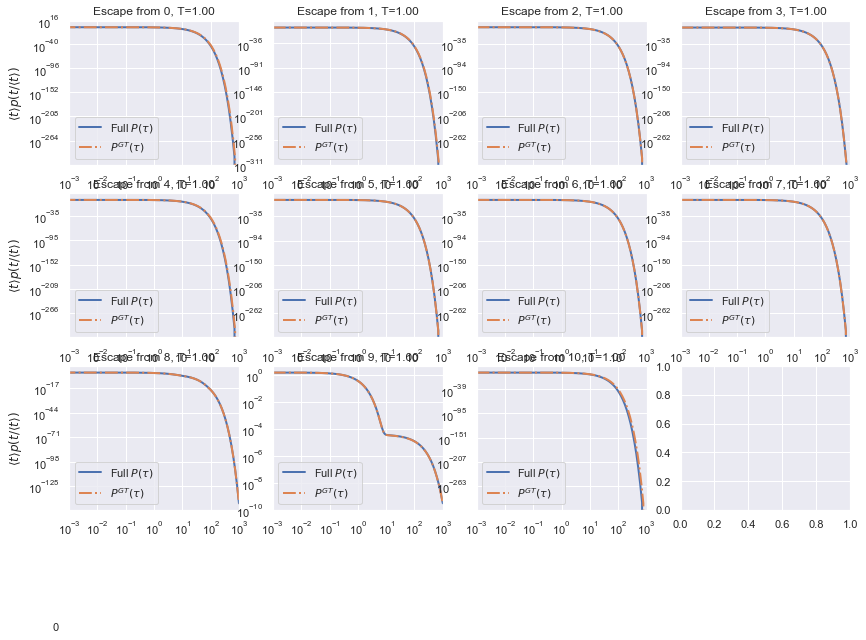

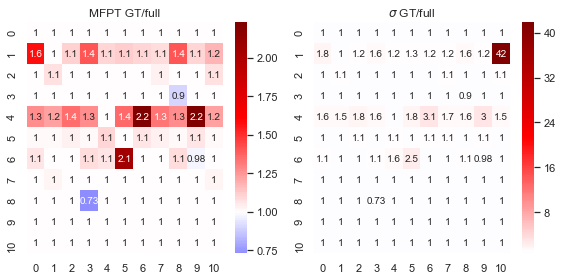

In [22]:
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

Removed 495 of 994 nodes, retained 50.201207243460765 percent


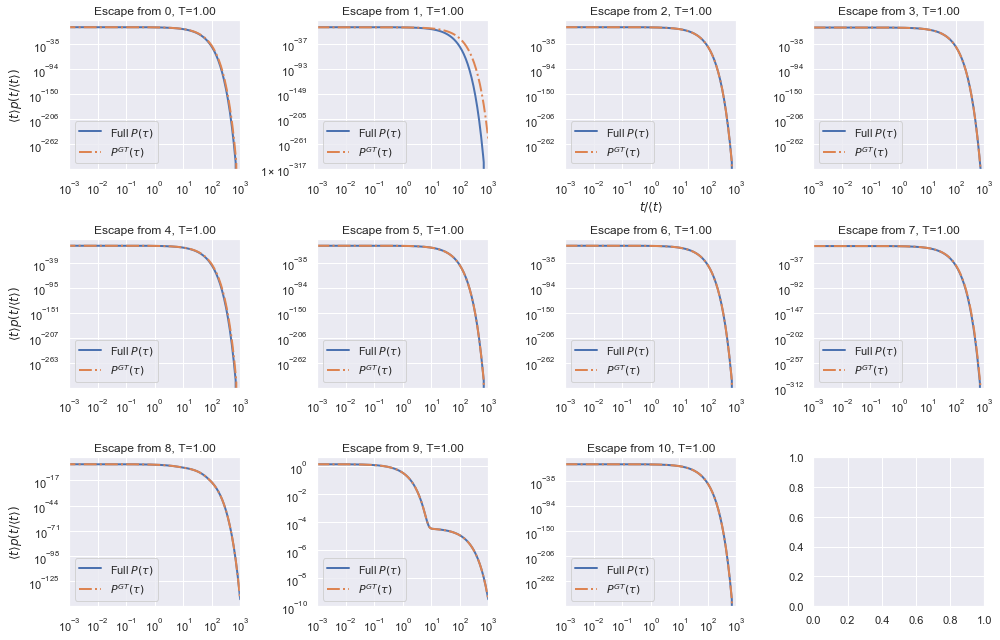

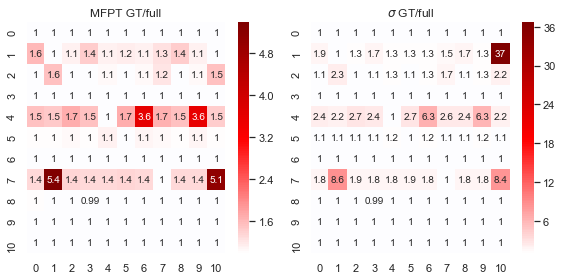

In [23]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='free_energy', percent_retained=50, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* When we keep 50%, the hybrid approach beats the free energy approach. Errors are smaller in passage stats between communities, and the escape-time distributions looks more accurate in reduced network

Removed 495 of 994 nodes, retained 50.201207243460765 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


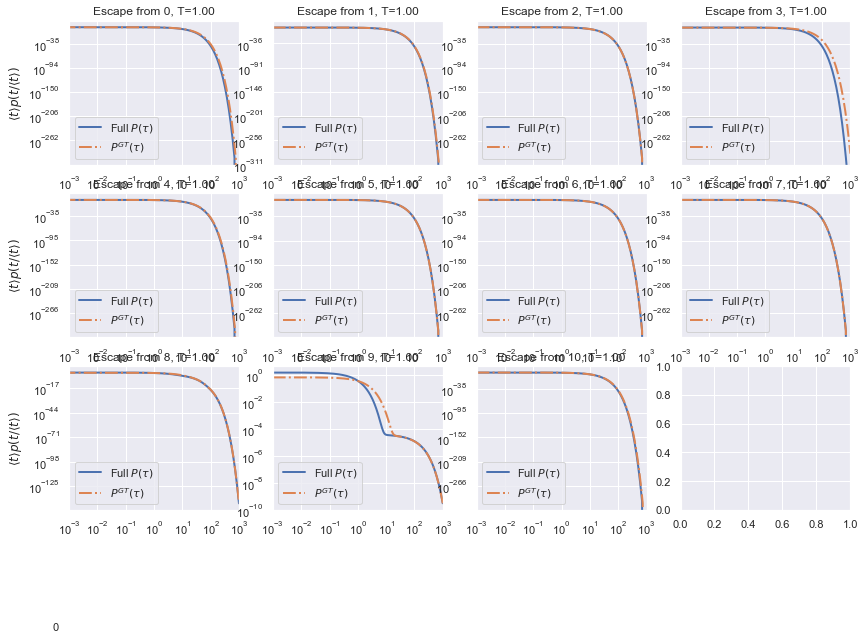

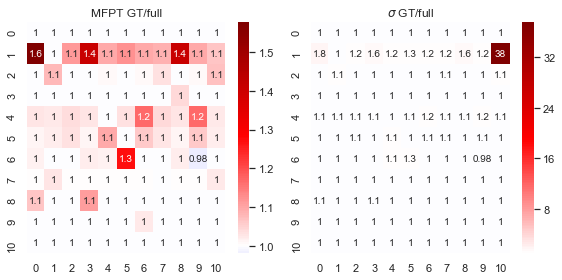

In [24]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='escape_time', percent_retained=50, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)

* Again, escape-time wins in terms of errors. But the escape time distributions are a little off compared to the hybrid approach

Removed 495 of 994 nodes, retained 50.201207243460765 percent


/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)
/Users/deepti/miniconda3/lib/python3.6/site-packages/matplotlib/ticker.py:1095: RuntimeWarning: divide by zero encountered in double_scalars
  coeff = np.round(x / b ** exponent)


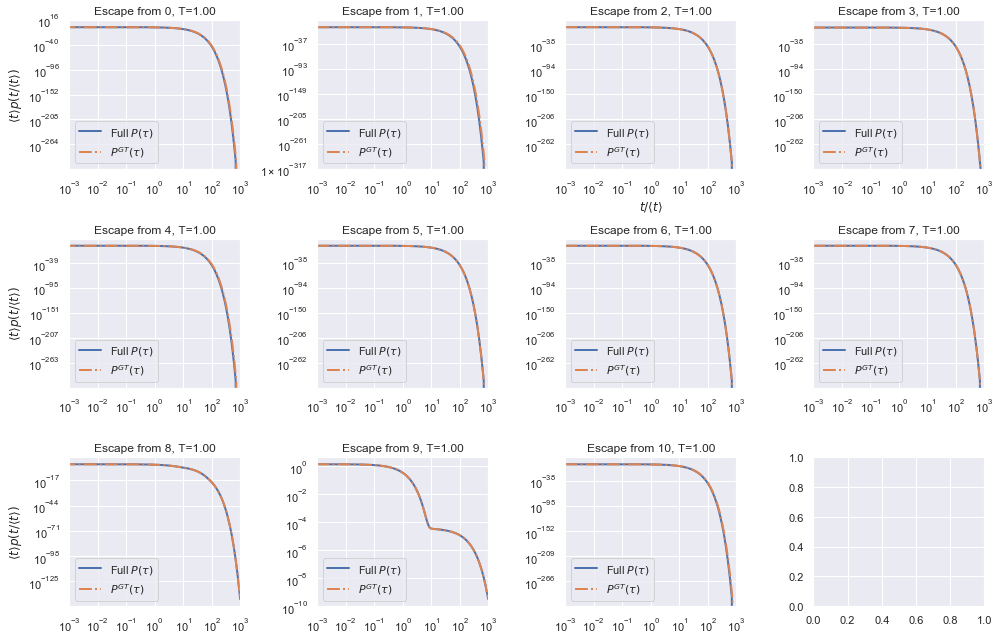

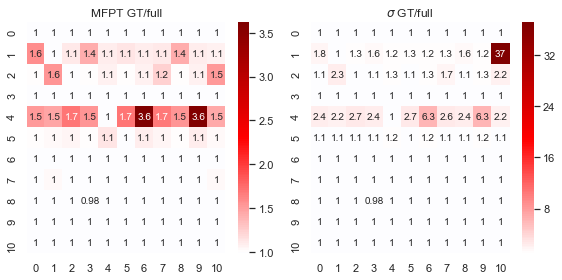

In [15]:
r_B, r_D, r_Q, r_N, r_BF, r_communities = pgt.prune_all_basins(beta=1.0, data_path=Path('KTN_data/9state'),
                                                        rm_type='combined', percent_retained=50, screen=False)
compare_basins(1.0, r_BF, r_Q, r_communities)
mfpt_mat, std_mat = get_first_second_moment_ratios_reduced_full(1.0, r_BF, r_Q, r_communities)